# Beat Analysis

Here I'm analysing the data generated from the rust code, to train on the model.

In [4]:
import os.path
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [7]:
TRACK_DIR = "../mixxx_data"

In [47]:
file = os.path.join(TRACK_DIR, "amelie.pickle")
with open(file, 'rb') as f:
    data = dict(pickle.load(f))

In [48]:
target = np.array(data['target'])[:,None]
hist = np.array(data['hist'])
joined_data = np.hstack((hist, target))
joined_data = np.clip(joined_data, 0, 1)

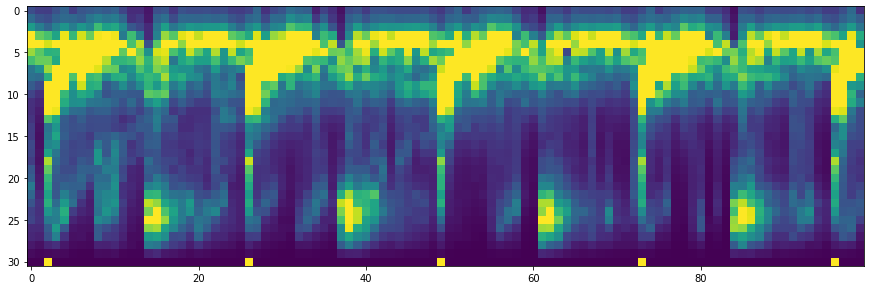

In [56]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x = 6000
ax.imshow(joined_data[x:x+100].T)